- [19.4 - Hierarchical Bayesian Approach](#19.4---Hierarchical-Bayesian-Approach)

## Chapter 19 - Metric Predicted Variable with One Nominal Predictor

In [94]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pmc
import theano.tensor as tt

from scipy.stats import norm
from IPython.display import Image

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
%config InlineBackend.figure_formats = {'retina',}
plt.style.use('seaborn-white')

color = '#87ceeb'

In [2]:
# Calculate Gamma shape and rate from mode and sd.
def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

### 19.4 - Hierarchical Bayesian Approach

In [3]:
df = pd.read_csv('data/FruitflyDataReduced.csv')
df.CompanionNumber = df.CompanionNumber.astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
Longevity          125 non-null int64
CompanionNumber    125 non-null category
Thorax             125 non-null float64
dtypes: category(1), float64(1), int64(1)
memory usage: 2.2 KB


In [4]:
df.head()

   Longevity CompanionNumber  Thorax
0         35       Pregnant8    0.64
1         37       Pregnant8    0.68
2         49       Pregnant8    0.68
3         46       Pregnant8    0.72
4         63       Pregnant8    0.72

In [5]:
df.CompanionNumber.cat.categories

Index(['None0', 'Pregnant1', 'Pregnant8', 'Virgin1', 'Virgin8'], dtype='object')

In [6]:
cat_idx = df.CompanionNumber.cat.codes.values
cat_idx

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int8)

In [7]:
df.CompanionNumber.value_counts()

Virgin8      25
Virgin1      25
Pregnant8    25
Pregnant1    25
None0        25
Name: CompanionNumber, dtype: int64

In [70]:
X = cat_idx
y = df.Longevity

yMean = y.mean()
ySD = y.std()

Ntotal = len(y)
NxLvl = len(df.CompanionNumber.cat.categories)

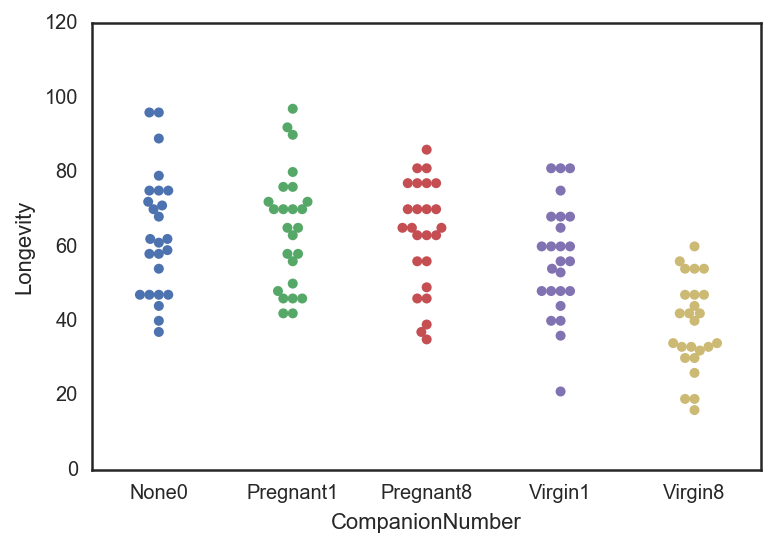

In [9]:
sns.swarmplot('CompanionNumber', 'Longevity', data=df);

In [ ]:
model {
    for ( i in 1:Ntotal ) {
      y[i] ~ dnorm( a0 + a[x[i]] , 1/ySigma^2 )
    }
    ySigma ~ dunif( ySD/100 , ySD*10 )
    a0 ~ dnorm( yMean , 1/(ySD*5)^2 ) 
    #
    for ( j in 1:NxLvl ) { a[j] ~ dnorm( 0.0 , 1/aSigma^2 ) }
    aSigma ~ dgamma( agammaShRa[1] , agammaShRa[2] ) 
    # Convert a0,a[] to sum-to-zero b0,b[] :
    for ( j in 1:NxLvl ) { m[j] <- a0 + a[j] } # cell means 
    b0 <- mean( m[1:NxLvl] )
    for ( j in 1:NxLvl ) { b[j] <- m[j] - b0 }
}  

#### Model (Kruschke, 2015)

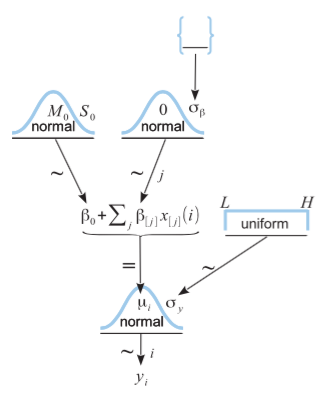

In [32]:
Image('images/fig19_2.png')

In [11]:
agammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)

with pmc.Model() as model:
    
    aSigma = pmc.Gamma('aSigma', agammaShRa[0], agammaShRa[1])
    a0 = pmc.Normal('a0', yMean, tau=1/(ySD*5)**2)
    a = pmc.Normal('a', 0.0, tau=1/aSigma**2, shape=NxLvl)
       
    ySigma = pmc.Uniform('ySigma', ySD/100, ySD*10)
    y = pmc.Normal('y', a0 + a[X], tau=1/ySigma**2, observed=y)
    
    # Convert a0,a to sum-to-zero b0,b 
    m = a0 + a
    b0 = pmc.Deterministic('b0', tt.mean(m))
    b = pmc.Deterministic('b', m - b0) 

Applied log-transform to aSigma and added transformed aSigma_log_ to model.
Applied interval-transform to ySigma and added transformed ySigma_interval_ to model.


In [67]:
with model:
    trace = pmc.sample(20000)

Assigned NUTS to aSigma_log_
Assigned NUTS to a0
Assigned NUTS to a
Assigned NUTS to ySigma_interval_
 [-----------------100%-----------------] 20000 of 20000 complete in 37.5 sec

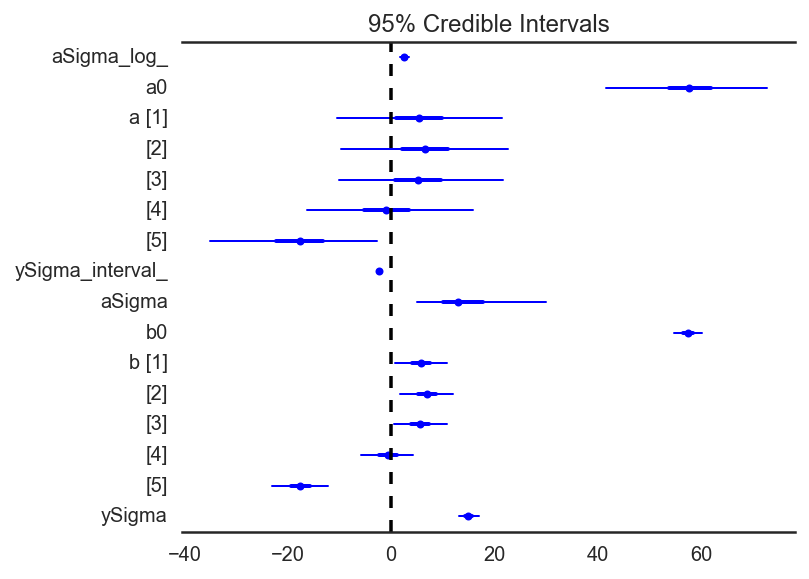

In [68]:
pmc.forestplot(trace);

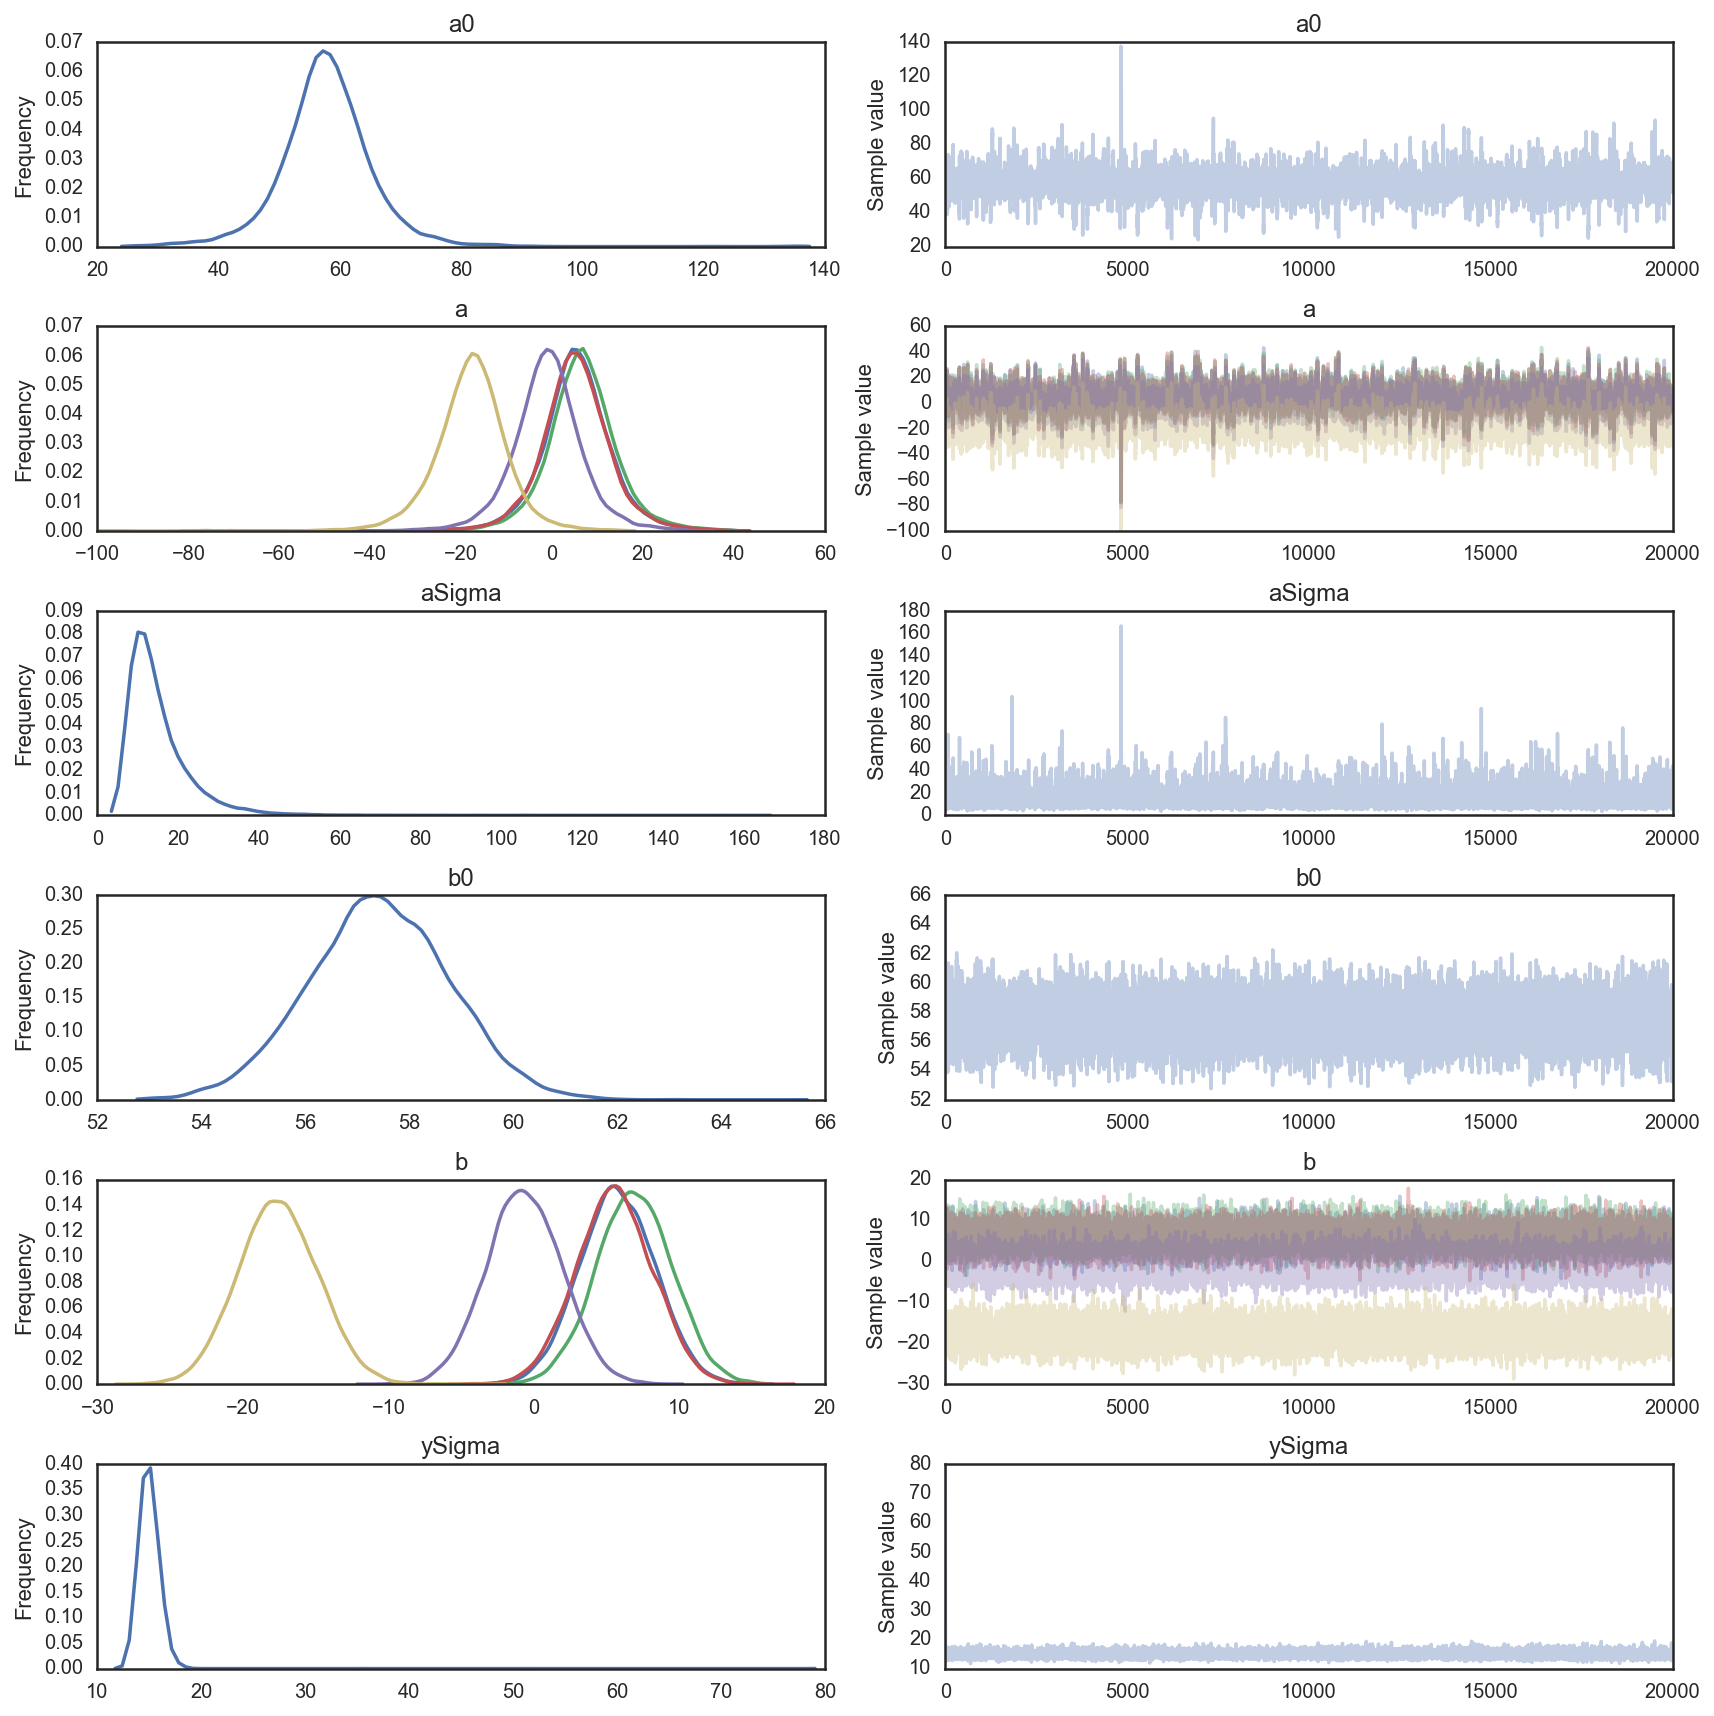

In [69]:
pmc.traceplot(trace);

In [106]:
burnin = 200

None0 = trace['b'][burnin:,0]
Pregnant1 = trace['b'][burnin:,1]
Pregnant8 = trace['b'][burnin:,2]
Virgin1 = trace['b'][burnin:,3]
Virgin8 = trace['b'][burnin:,4]

scale = trace['aSigma'][burnin:]

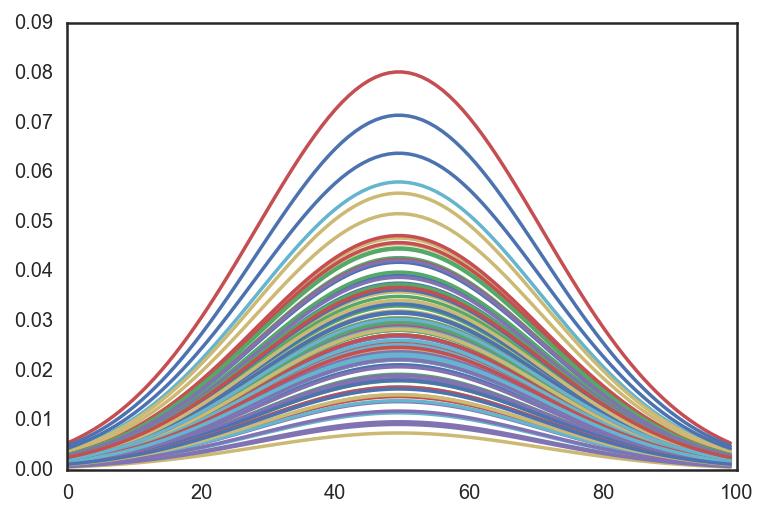

In [107]:
for i in np.arange(0, 19800, 200):
    rv = norm(loc=None0[i], scale=scale[i])
    xrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
    plt.plot(rv.pdf(xrange))

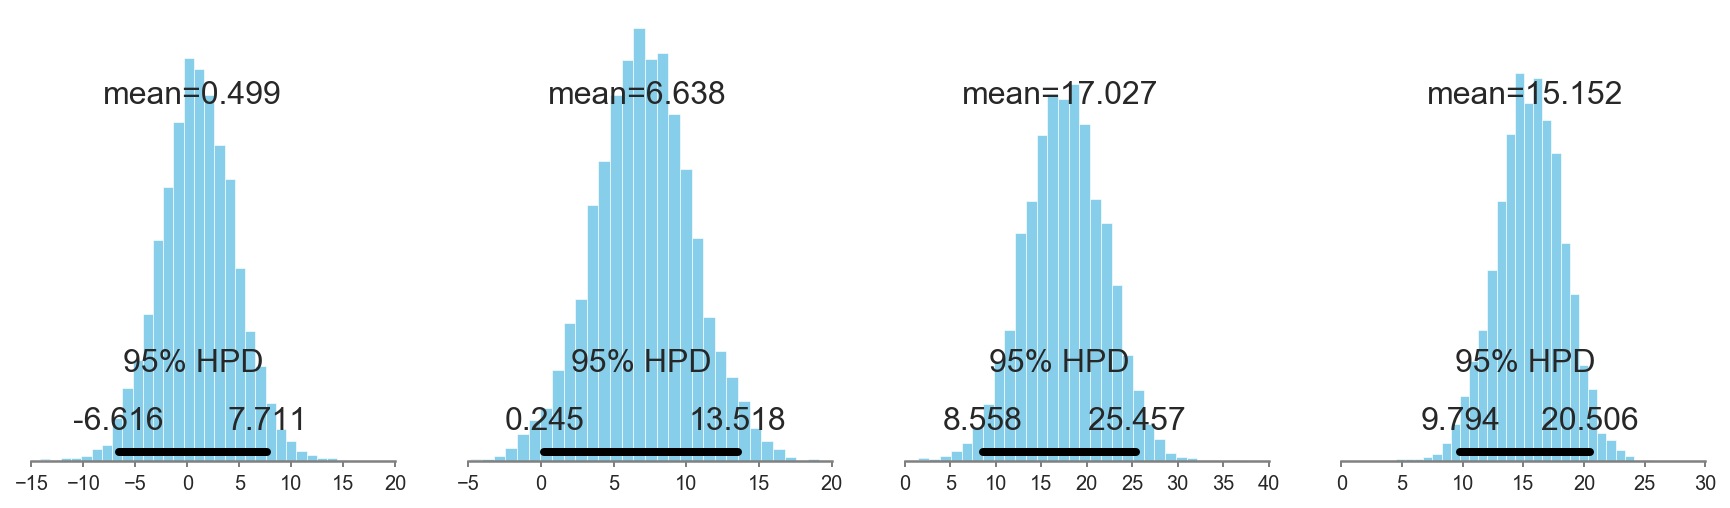

In [86]:
fig, axes = plt.subplots(1,4, figsize=(15,4))

pmc.plot_posterior(np.mean([Pregnant1, Pregnant8], axis=0)-None0, color=color, ax=axes[0])
pmc.plot_posterior(np.mean([Pregnant1, Pregnant8, None0], axis=0)-Virgin1, color=color, ax=axes[1])
pmc.plot_posterior(Virgin1-Virgin8, color=color, ax=axes[2])
pmc.plot_posterior(np.mean([Pregnant1, Pregnant8, None0], axis=0)-np.mean([Virgin1, Virgin8], axis=0), color=color, ax=axes[3])